## Project Overview

This project simulates an A/B test for an e-commerce platform like Amazon, where the objective is to determine if changing the position of the "Buy Now" button influences user behavior and purchase rates.

We simulate a user dataset with:
- Group assignment (Control vs Test)
- Page visit behavior
- Click-through behavior
- Final purchase conversion
- Time spent on page
- Country and Device segmentation

The aim is to analyze whether the new button placement leads to:
- Higher click-through rates (CTR)
- Increased conversion rate


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import random

np.random.seed(42)

# Simulate users
n_users = 5000
user_ids = np.arange(1, n_users + 1)
groups = np.random.choice(['control', 'test'], size=n_users, p=[0.5, 0.5])

# Countries (realistic traffic)
countries = np.random.choice(['US', 'DE', 'IN', 'IT'], size=n_users, p=[0.4, 0.2, 0.25, 0.15])

# Device type
devices = np.random.choice(['Desktop', 'Mobile'], size=n_users, p=[0.6, 0.4])

# Did they visit the product page?
visited_page = np.random.choice([1, 0], size=n_users, p=[0.9, 0.1])

# Time on page (seconds)
time_on_page = [np.random.normal(40, 10) if vp == 1 else 0 for vp in visited_page]
time_on_page = np.clip(time_on_page, 0, None)  # Remove negative values

# Clicked "Buy Now"
clicked = []
for g, vp in zip(groups, visited_page):
    if vp == 0:
        clicked.append(0)
    else:
        if g == 'control':
            clicked.append(np.random.choice([1, 0], p=[0.20, 0.80]))
        else:
            clicked.append(np.random.choice([1, 0], p=[0.28, 0.72]))  # Higher CTR in test

# Purchased
purchased = []
for c in clicked:
    if c == 0:
        purchased.append(0)
    else:
        purchased.append(np.random.choice([1, 0], p=[0.65, 0.35]))  # From those who clicked

# Build DataFrame
df = pd.DataFrame({
    'user_id': user_ids,
    'group': groups,
    'country': countries,
    'device_type': devices,
    'visited_page': visited_page,
    'time_on_page': np.round(time_on_page, 2),
    'clicked_buy_now': clicked,
    'purchased': purchased
})

df.head()


,user_id,group,country,device_type,visited_page,time_on_page,clicked_buy_now,purchased
0,1,control,US,Desktop,1,31.96,0,0
1,2,test,DE,Desktop,1,45.86,1,0
2,3,test,IT,Desktop,1,53.06,0,0
3,4,test,US,Mobile,1,27.73,0,0
4,5,control,IT,Desktop,1,57.12,0,0


## Step 2: Exploratory Data Analysis (EDA)

We now analyze group-wise metrics:
- Conversion Rate
- Time spent on product page
- Click-through rate (Buy Now button)

### Observations:
- The test group is expected to have higher click and purchase rates due to improved button visibility.
- Time-on-page helps interpret user engagement.


group
control    2500
test       2500
Name: count, dtype: int64
group
control    0.118
test       0.164
Name: purchased, dtype: float64


<ipython-input-3-2859186743>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conversion_summary, x='Group', y='Conversion Rate', palette='Set2')


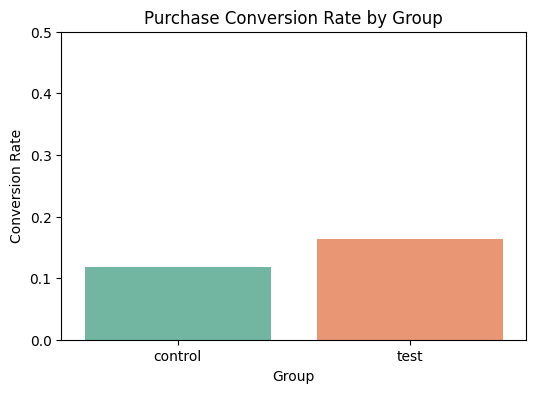

<ipython-input-3-2859186743>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['visited_page'] == 1], x='group', y='time_on_page', palette='pastel')


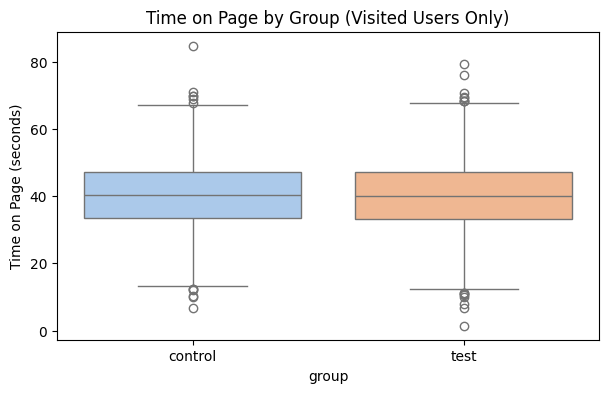

<ipython-input-3-2859186743>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ctr_summary, x='Group', y='Click-through Rate', palette='coolwarm')


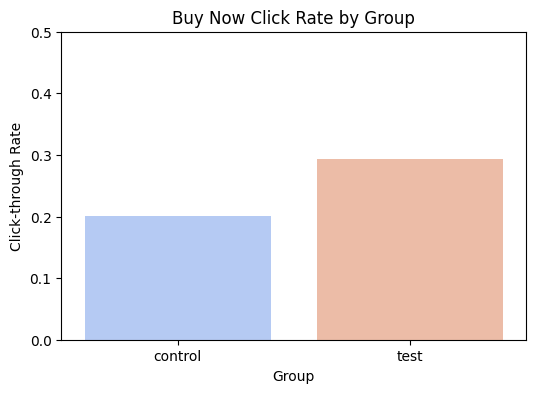

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check basic group distribution
print(df['group'].value_counts())
print(df.groupby('group')['purchased'].mean())  # Basic conversion rates

# Conversion Rate Comparison
conversion_summary = df.groupby('group')['purchased'].mean().reset_index()
conversion_summary.columns = ['Group', 'Conversion Rate']

plt.figure(figsize=(6, 4))
sns.barplot(data=conversion_summary, x='Group', y='Conversion Rate', palette='Set2')
plt.title('Purchase Conversion Rate by Group')
plt.ylim(0, 0.5)
plt.show()

# Time on Page Comparison
plt.figure(figsize=(7, 4))
sns.boxplot(data=df[df['visited_page'] == 1], x='group', y='time_on_page', palette='pastel')
plt.title('Time on Page by Group (Visited Users Only)')
plt.ylabel('Time on Page (seconds)')
plt.show()

# Click-through Rate by Group
ctr_summary = df[df['visited_page'] == 1].groupby('group')['clicked_buy_now'].mean().reset_index()
ctr_summary.columns = ['Group', 'Click-through Rate']

plt.figure(figsize=(6, 4))
sns.barplot(data=ctr_summary, x='Group', y='Click-through Rate', palette='coolwarm')
plt.title('Buy Now Click Rate by Group')
plt.ylim(0, 0.5)
plt.show()


## Step 3: A/B Test Statistical Analysis

In this step, we evaluate whether the changes introduced in the Variant group (B) led to a statistically significant improvement in user behavior.

We check:
- **Page Visit Rate** using Chi-Squared Test
- **Time on Page** using T-Test
- **Conversion Rate** using Chi-Squared Test

A p-value < 0.05 in any of these tests indicates that the difference observed is statistically significant.


In [7]:
from scipy.stats import chi2_contingency, ttest_ind

# 1. Chi-Squared Test – Page Visit Rate
visit_ct = pd.crosstab(df['group'], df['visited_page'])
chi2, p, _, _ = chi2_contingency(visit_ct)
print("Page Visit Rate:")
print(visit_ct)
print(f"Chi-squared p-value: {p:.4f}\n")

# 2. T-Test – Time Spent on Page (Only if visited)
control_time = df[(df['group'] == 'control') & (df['visited_page'] == 1)]['time_on_page']
variant_time = df[(df['group'] == 'test') & (df['visited_page'] == 1)]['time_on_page']

t_stat, p_val = ttest_ind(control_time, variant_time, equal_var=False)
print("Time on Page Comparison:")
print(f"T-test p-value: {p_val:.4f}\n")

# 3. Chi-Squared Test – Purchase Rate
purchase_ct = pd.crosstab(df['group'], df['purchased'])
chi2, p, _, _ = chi2_contingency(purchase_ct)
print("Conversion Rate:")
print(purchase_ct)
print(f"Chi-squared p-value: {p:.4f}")


Page Visit Rate:
visited_page    0     1
group                  
control       252  2248
test          260  2240
Chi-squared p-value: 0.7440

Time on Page Comparison:
T-test p-value: 0.9811

Conversion Rate:
purchased     0    1
group               
control    2205  295
test       2090  410
Chi-squared p-value: 0.0000


## 📊 Visual Summary

Below are bar plots summarizing the key performance metrics of our A/B test, comparing control and test groups across:

- Page Visit Rate
- Average Time on Page (only for those who visited the page)
- Conversion Rate

These charts visually reinforce our statistical findings.


<ipython-input-8-2163748803>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=visit_rates, x='group', y='visited_page', palette='Set2')


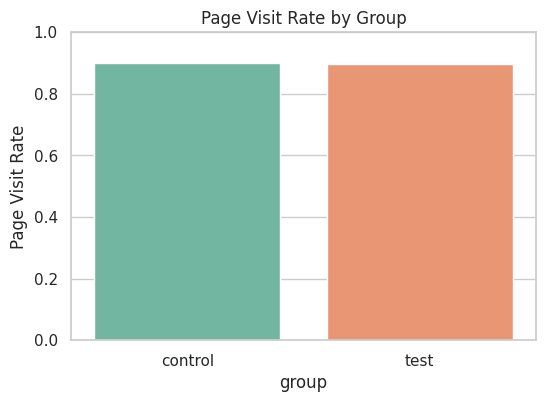

<ipython-input-8-2163748803>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=time_on_page_summary, x='group', y='time_on_page', palette='Set1')


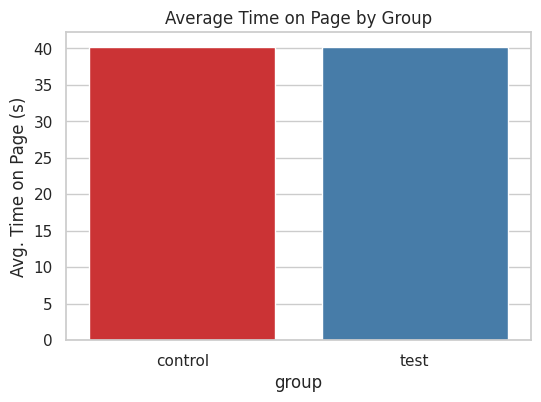

<ipython-input-8-2163748803>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conversion_rates, x='group', y='purchased', palette='Set3')


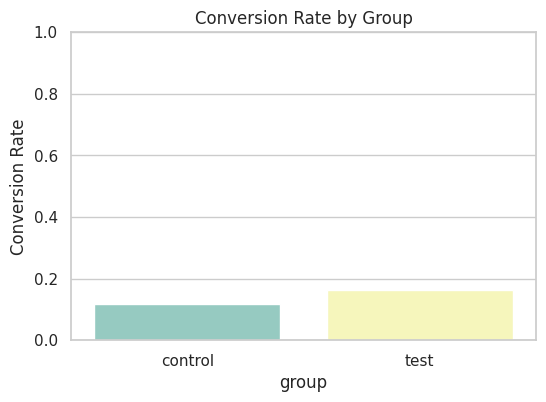

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. Page Visit Rate
visit_rates = df.groupby('group')['visited_page'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=visit_rates, x='group', y='visited_page', palette='Set2')
plt.ylim(0, 1)
plt.ylabel('Page Visit Rate')
plt.title('Page Visit Rate by Group')
plt.show()

# 2. Average Time on Page
time_on_page_summary = df[df['visited_page'] == 1].groupby('group')['time_on_page'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=time_on_page_summary, x='group', y='time_on_page', palette='Set1')
plt.ylabel('Avg. Time on Page (s)')
plt.title('Average Time on Page by Group')
plt.show()

# 3. Conversion Rate
conversion_rates = df.groupby('group')['purchased'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=conversion_rates, x='group', y='purchased', palette='Set3')
plt.ylim(0, 1)
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Group')
plt.show()
